# Performance measures extraction

#### Imports and settings

In [220]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np

In [221]:
# Interesting results
outputs = [115, 116, 117, 118, 119, 120]

# Parameters we focus on
params = [
    'Total time spent by all map tasks (ms)',
    'Total time spent by all reduce tasks (ms)',
    'CPU time spent (ms)',
    'GC time elapsed (ms)',
    'Reduce shuffle bytes'
]

# Workflow names
jobs = ['count', 'frequency']

# Create a dataframe to store the results
df = pd.DataFrame(columns=['size', 'workflow', 'reducers', 'job'] + params)

# Base directory
base_dir = "../resources/performance/output/output_"


## Data extraction

In [222]:
for output in outputs:
    output_dir = base_dir + str(output).zfill(5)
    
    # Read parameters.txt values
    with open(os.path.join(output_dir, 'parameters.txt')) as f:
        lines = f.readlines()
        data = {}
        for line in lines:
            if 'workflow' in line:
                data['workflow'] = line.split('=')[-1].strip()
            elif 'reducers' in line:
                data['reducers'] = int(line.split('=')[-1].strip())

    # Subfolders in output directory
    subfolders = [f.path for f in os.scandir(output_dir) if f.is_dir()]
    
    # Read log.txt files
    for subfolder in subfolders:
        # Extract size from subfolder name
        data['size'] = subfolder.split('file_')[-1]
        
        with open(os.path.join(subfolder, 'log.txt')) as f:
            lines = f.readlines()
            for line in lines:
                for param in params:
                    if param in line and param not in data:
                        data[param] = float(line.split('=')[-1].strip())
        data['job'] = 'count'
        df.loc[len(df)] = data

        with open(os.path.join(subfolder, 'log.txt')) as f:
            lines = f.readlines()
            for line in lines:
                for param in params:
                    if param in line:
                        data[param] = float(line.split('=')[-1].strip())
        data['job'] = 'frequency'
        df.loc[len(df)] = data

df.columns = df.columns.str.replace('\t', ' ', regex=False)

In [223]:
print(df)

   size                  workflow  reducers        job  \
0   3MB   letterFrequencyCombiner         1      count   
1   3MB   letterFrequencyCombiner         1  frequency   
2   3KB   letterFrequencyCombiner         1      count   
3   3KB   letterFrequencyCombiner         1  frequency   
4   3GB   letterFrequencyCombiner         1      count   
5   3GB   letterFrequencyCombiner         1  frequency   
6   3MB   letterFrequencyCombiner         2      count   
7   3MB   letterFrequencyCombiner         2  frequency   
8   3KB   letterFrequencyCombiner         2      count   
9   3KB   letterFrequencyCombiner         2  frequency   
10  3GB   letterFrequencyCombiner         2      count   
11  3GB   letterFrequencyCombiner         2  frequency   
12  3MB   letterFrequencyCombiner         3      count   
13  3MB   letterFrequencyCombiner         3  frequency   
14  3KB   letterFrequencyCombiner         3      count   
15  3KB   letterFrequencyCombiner         3  frequency   
16  3GB   lett

## Data plotting

In [224]:
# Melt data
df_melted = df.melt(id_vars=['size', 'workflow', 'reducers', 'job'], var_name='param', value_name='value')
df_melted['workflow_job'] = df_melted['workflow'] + ' | ' + df_melted['job']

# print(df_melted)

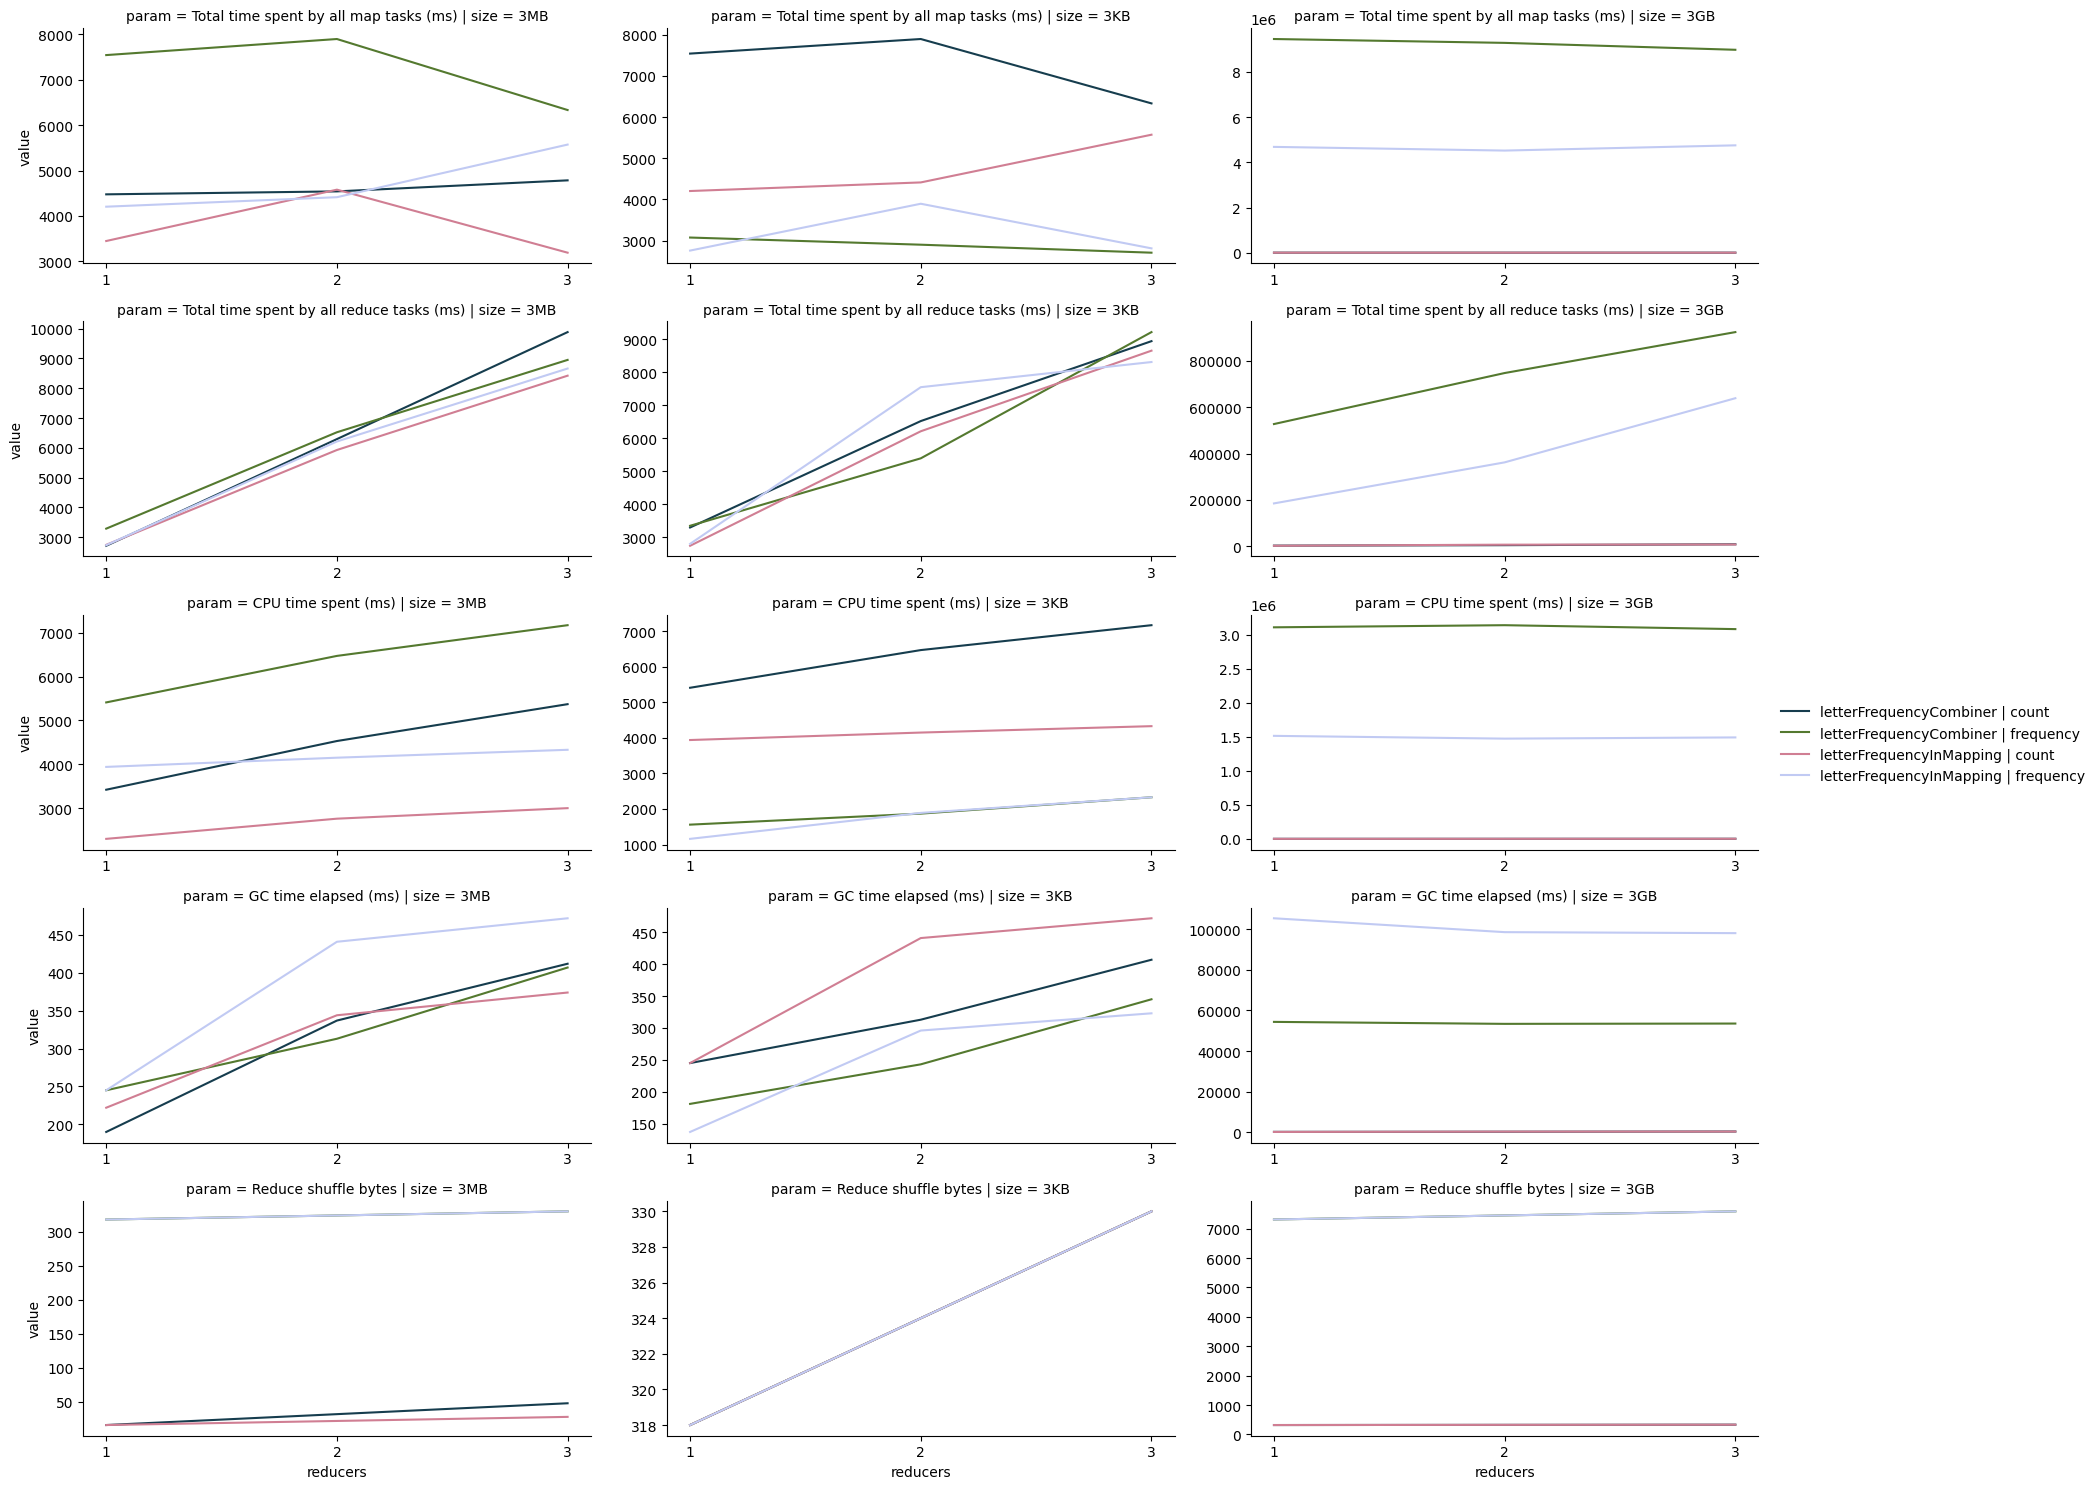

In [225]:
# Generate grid
g = sns.FacetGrid(df_melted, row="param", col="size", sharey=False, sharex=False, height=3, aspect=2)

# Genrate plots
g = g.map_dataframe(sns.lineplot, x="reducers", y="value", hue="workflow_job", palette="cubehelix")
g.add_legend()
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig('png/performances.png')
plt.show()